#  <span style="color:dodgerblue">US MAPS </span>
<span style="color:cyan">**2024 Tidytuesday  Week 15** </span>

In [ ]:
pwd()

## Setup

### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd


In [2]:
from matplotlib import rcParams
from matplotlib import font_manager

font_dirs =  ['/Library/Fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

rcParams['font.family'] = 'Roboto'
#rcParams['font.size'] = '12'

### Data

In [27]:
import os
path_dir = os.getcwd()

In [38]:
ccc_url ='https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2023/2023-05-09/childcare_costs.csv'
counties_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2023/2023-05-09/counties.csv'
shape_file = '/usmap_shape_files/cb_2018_us_state_500k.shp'

In [42]:
ccc_data = pd.read_csv(ccc_url)
counties_data = pd.read_csv(counties_url)
map_data = gpd.read_file(path_dir + shape_file)

In [41]:
map_data.head(3)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."


## Data Wrangling  - EDA

### State unemployment

In [49]:
counties_data.columns  = ['fips', 'county', 'state', 'abbr']
counties_data.head(2)

,fips,county,state,abbr
0,1001,Autauga County,Alabama,AL
1,1003,Baldwin County,Alabama,AL


In [50]:
unemp_data = ccc_data[['county_fips_code', 'study_year', 'unr_16', 'funr_16', 'munr_16']]
unemp_data.columns = ['fips', 'year', 'rate', 'female', 'male']
unemp_data.head(3)


,fips,year,rate,female,male
0,1001,2008,5.42,4.41,6.32
1,1001,2009,5.93,5.72,6.11
2,1001,2010,6.21,5.57,6.78


In [52]:
df = pd.merge(
    left=unemp_data,
    right=counties_data,
    on='fips')
dff = df[['year', 'state', 'rate', 'male', 'female']]
dff.head(2)

,year,state,rate,male,female
0,2008,Alabama,5.42,6.32,4.41
1,2009,Alabama,5.93,6.11,5.72


In [60]:
rates_by_state = dff.groupby(['year', 'state']).mean().reset_index()

,year,state,rate,male,female
0,2018,Alabama,8.039701,8.078507,7.970448
1,2018,Alaska,9.407241,10.849310,7.653448


### Merging with shape files

In [83]:
mdf = pd.merge(
    left = map_data,
    right=rates_by_state,
    left_on='NAME',
    right_on='state',
    how = 'left'
)
mdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   566 non-null    object  
 1   STATENS   566 non-null    object  
 2   AFFGEOID  566 non-null    object  
 3   GEOID     566 non-null    object  
 4   STUSPS    566 non-null    object  
 5   NAME      566 non-null    object  
 6   LSAD      566 non-null    object  
 7   ALAND     566 non-null    int64   
 8   AWATER    566 non-null    int64   
 9   geometry  566 non-null    geometry
 10  year      561 non-null    float64 
 11  state     561 non-null    object  
 12  rate      561 non-null    float64 
 13  male      561 non-null    float64 
 14  female    561 non-null    float64 
dtypes: float64(4), geometry(1), int64(2), object(8)
memory usage: 66.5+ KB


### Remove missing values

In [86]:
mdf = mdf.dropna()
mdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 561 entries, 0 to 565
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   561 non-null    object  
 1   STATENS   561 non-null    object  
 2   AFFGEOID  561 non-null    object  
 3   GEOID     561 non-null    object  
 4   STUSPS    561 non-null    object  
 5   NAME      561 non-null    object  
 6   LSAD      561 non-null    object  
 7   ALAND     561 non-null    int64   
 8   AWATER    561 non-null    int64   
 9   geometry  561 non-null    geometry
 10  year      561 non-null    float64 
 11  state     561 non-null    object  
 12  rate      561 non-null    float64 
 13  male      561 non-null    float64 
 14  female    561 non-null    float64 
dtypes: float64(4), geometry(1), int64(2), object(8)
memory usage: 70.1+ KB


### Filtering out Alaska, Hawaii adn Puerto Rico

In [90]:
mdf  = mdf[~mdf['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

### Keeping Only 2028 data

In [94]:
rates_2018 = mdf[mdf.year == 2018].reset_index(drop=True)
rates_2018.head(2)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,year,state,rate,male,female
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",2018.0,Mississippi,9.19061,9.022317,9.409146
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",2018.0,North Carolina,7.00270,6.999800,7.013300


# Mapping

## Overall rates of unemployment in 2018

In [93]:
rates_2018_all = rates_2018.drop(columns = ['year', 'state', 'male', 'female'])

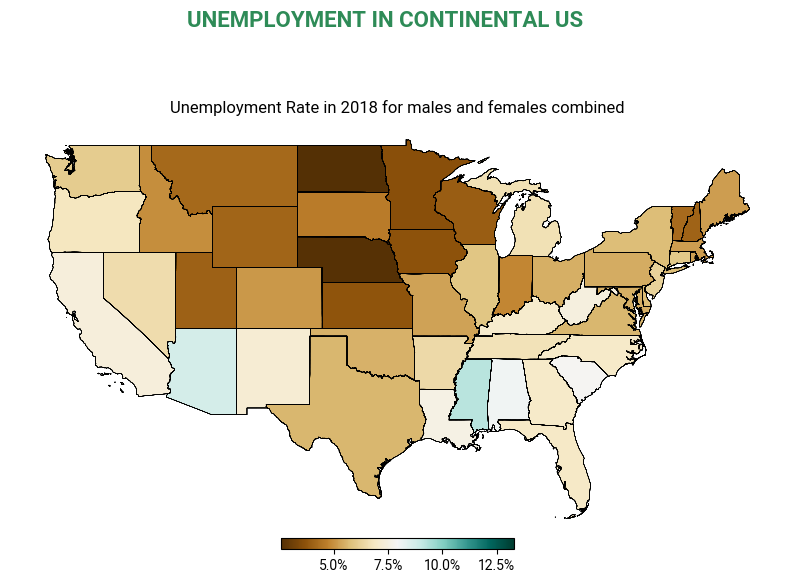

In [147]:
ax = mdf.boundary.plot(
    edgecolor = 'black',
    linewidth = .2,
    figsize = (10, 7))
mdf.plot(
    ax = ax,
    column = 'rate',
    legend = True, cmap = 'BrBG',
    legend_kwds={
        'shrink': 0.3, 
        'orientation' : 'horizontal',
        'format' : '%.1f%%' ,
        'pad': 0.0 
        })
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for edge in ['right', 'left', 'top', 'bottom']:
    ax.spines[edge].set_visible(False)

plt.suptitle(
    'UNEMPLOYMENT IN CONTINENTAL US',
    size=16, color = 'seagreen', weight='bold')
plt.title('Unemployment Rate in 2018 for males and females combined',fontsize=12)
plt.show()

## Unemployment rates in 2018 among <span style="color:dodgerblue">*males*</span>

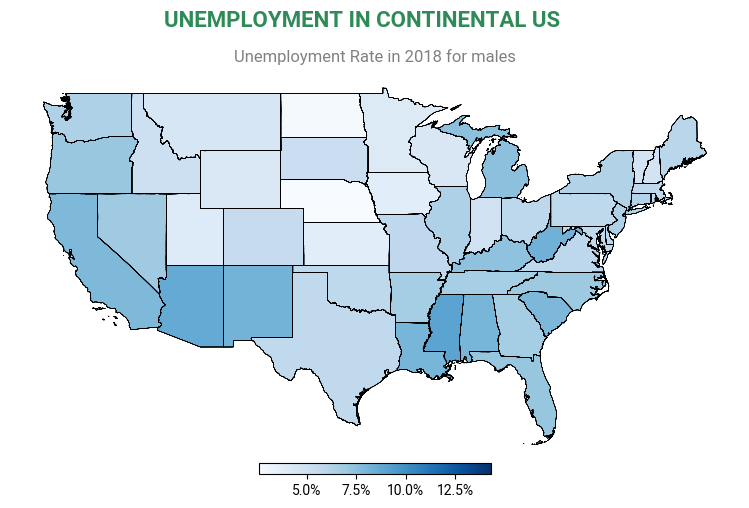

In [146]:
ax = mdf.boundary.plot(
    edgecolor = 'black',
    linewidth = .2,
    figsize = (10, 6))
mdf.plot(
    ax = ax,
    column = 'male',
    legend = True, cmap = 'Blues',
    legend_kwds={
        'shrink': 0.3, 
        'orientation' : 'horizontal',
        'format' : '%.1f%%' ,
        'pad': 0.0
        })
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for edge in ['right', 'left', 'top', 'bottom']:
    ax.spines[edge].set_visible(False)

plt.suptitle(
    'UNEMPLOYMENT IN CONTINENTAL US',
    size=16, color = 'seagreen', weight='bold')
plt.title('Unemployment Rate in 2018 for males',fontsize=12, color = 'grey')
plt.show()

## Unemployment rates in 2018 among <span style="color:seagreen">*females*</span>

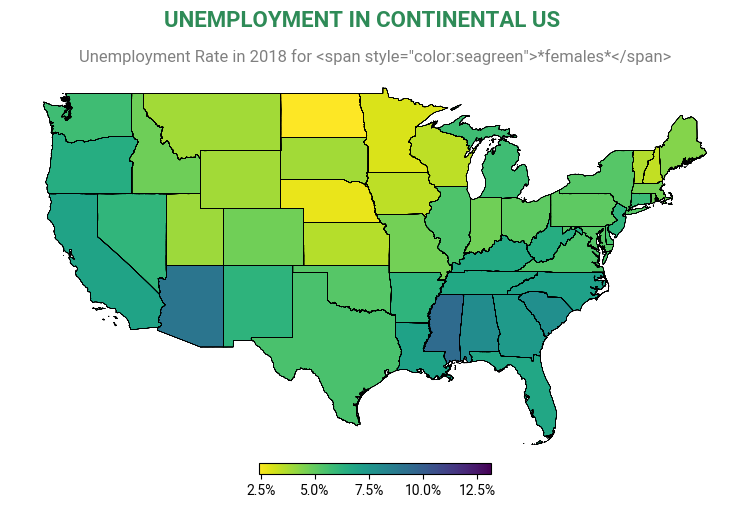

In [151]:
ax = mdf.boundary.plot(
    edgecolor = 'black',
    linewidth = .2,
    figsize = (10, 6))
mdf.plot(
    ax = ax,
    column = 'female',
    legend = True, cmap = 'viridis_r',
    legend_kwds={
        'shrink': 0.3, 
        'orientation' : 'horizontal',
        'format' : '%.1f%%' ,
        'pad': 0.0
        })
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for edge in ['right', 'left', 'top', 'bottom']:
    ax.spines[edge].set_visible(False)

plt.suptitle(
    'UNEMPLOYMENT IN CONTINENTAL US',
    size=16, color = 'seagreen', weight='bold')
plt.title('Unemployment Rate in 2018 for <span style="color:seagreen">*females*</span>',fontsize=12, color = 'grey')
plt.show()